**Week-10 Assignment**

Refer to the Notebook on HAR using CNN and LSTM. Implement the approach using some activity dataset other than UCF50.

In [2]:
# Import the required libraries.
import os
import cv2
import math
import random
import pydot
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

['climb', 'climb_stairs', 'eat', 'jump', 'laugh', 'push', 'run', 'sit', 'stand', 'talk', 'walk']
10
7
4
8
1


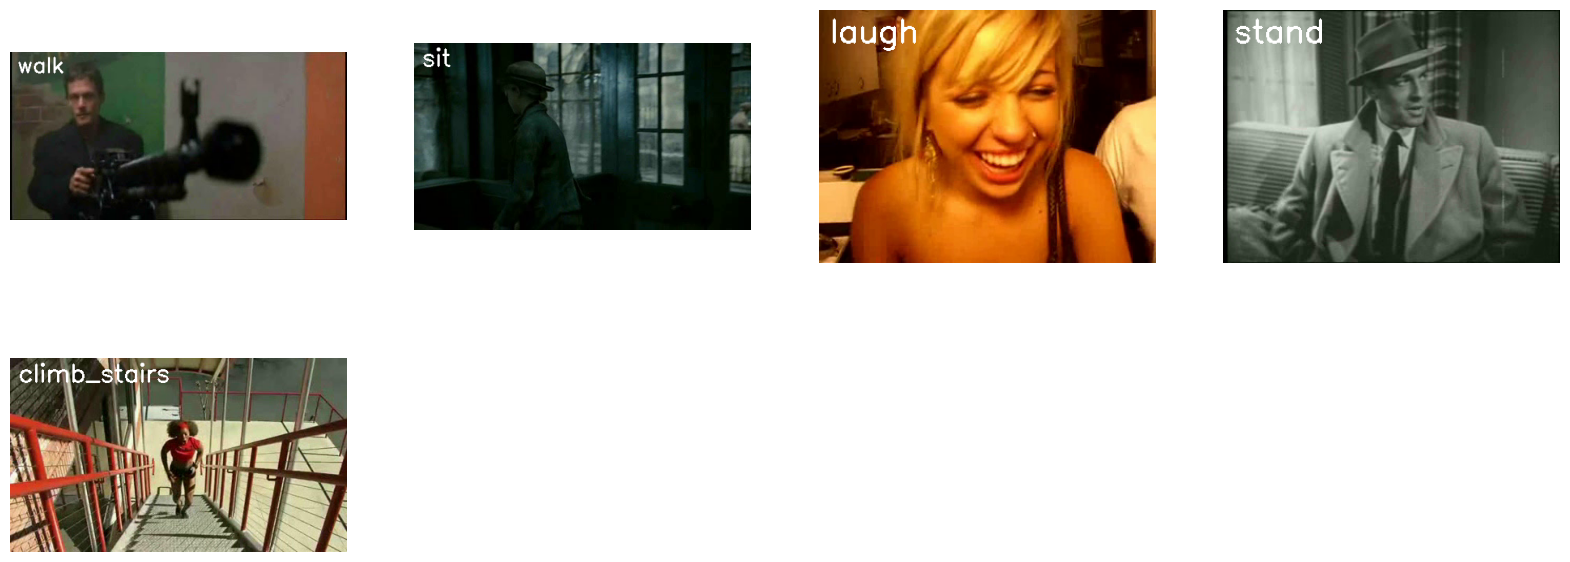

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in UCF50.
dataset_dir = 'C:\\Users\\anukr\\Downloads\\HMDB_dataset'
all_classes_names = os.listdir(dataset_dir)
print(all_classes_names)

# Generate a list of 5 random values. The values will be between 0-50,
# where 50 is the total number of classes in the dataset.
random_range = random.sample(range(len(all_classes_names)), 5)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    print(random_index)
    # Retrieve a Class Name using the Random Index.
    selected_class_name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(
        os.path.join(dataset_dir, selected_class_name))

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(os.path.join(
        dataset_dir, selected_class_name, selected_video_file_name))

    # Read the first frame of the video file.
    ret, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    if not ret:
        print(f"Failed to read video: {selected_video_file_name}")
        continue

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_name, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()

In [6]:
def frames_extraction(video_path):
    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,
                         frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop.
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255.0

        # Append the normalized frame into the frames list.
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [9]:
def create_dataset():
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list.
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays.
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [15]:
#define the necesscary variables

CLASSES_LIST = ['run', 'stand', 'talk', 'climb', 'walk']
DATASET_DIR = 'C:\\Users\\anukr\\Downloads\\HMDB_dataset'
SEQUENCE_LENGTH = 10  # Number of frames to extract from each video
IMAGE_HEIGHT = 32     # Height of the resized frame
IMAGE_WIDTH = 32      # Width of the resized frame

In [14]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: run
Extracting Data of Class: stand
Extracting Data of Class: talk
Extracting Data of Class: climb
Extracting Data of Class: walk


In [16]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors 1 0 0 0 0, 0 1 0 0 0
one_hot_encoded_labels = to_categorical(labels)

In [17]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

In [19]:
def create_convlstm_model():
    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True,
                         input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))

    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))
    ########################################################################################################################

    # Display the model summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [20]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
# Display the success message.
print("Model Created Successfully!")

d:\CV ASSIGNMENT\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 30, 30, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 15, 15, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 15, 15, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 10, 13, 13, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 10, 7, 7, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 7, 7, 8)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 10, 5, 5, 14)   │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 10, 3, 3, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 3, 3, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 10, 1, 1, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 10, 1, 1, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,805 (132.05 KB)

 Trainable params: 33,805 (132.05 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


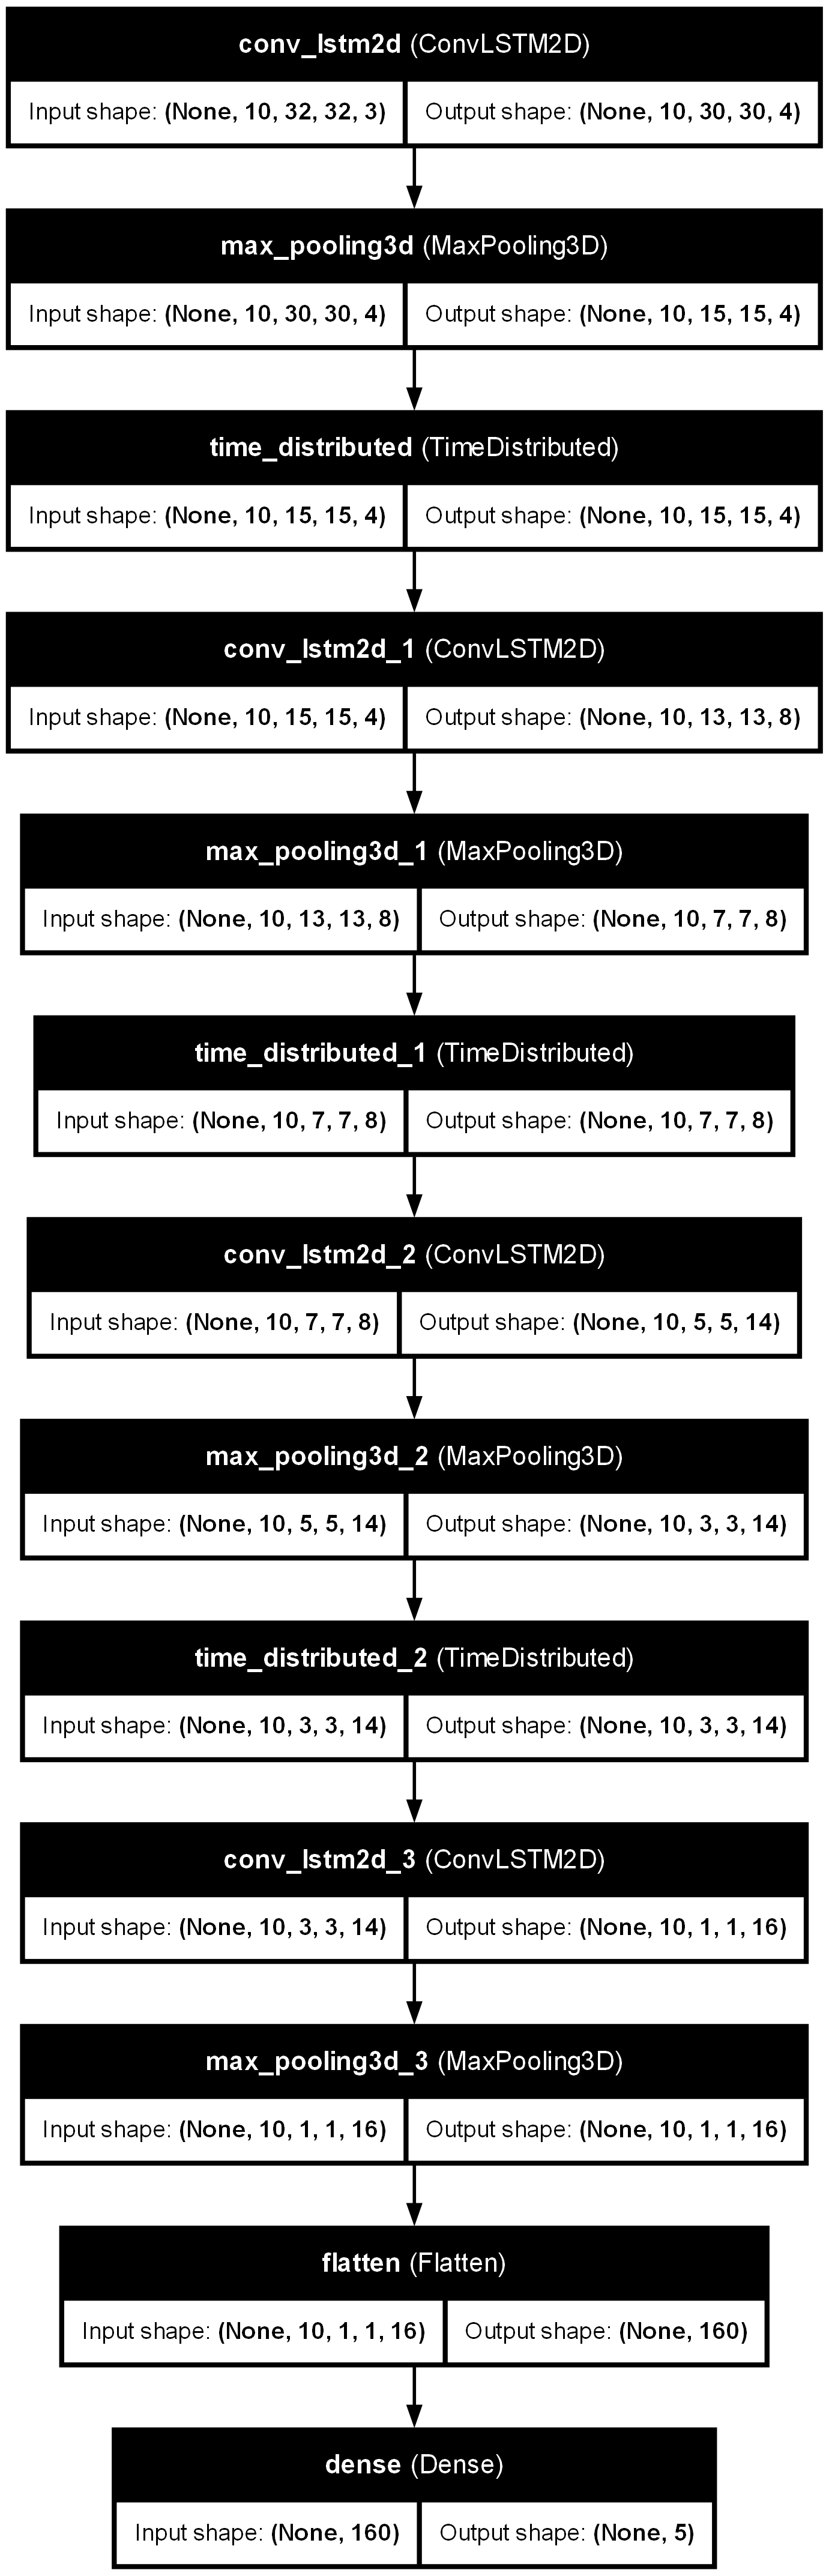

In [12]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png',
           show_shapes=True, show_layer_names=True)

In [21]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy',
                       optimizer='Adam', metrics=["accuracy"])

In [22]:
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(
    x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(
    current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{
    model_evaluation_loss:.4f}___Accuracy_{model_evaluation_accuracy:.4f}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.4642 - loss: 1.4942 - val_accuracy: 0.5429 - val_loss: 1.3142
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4889 - loss: 1.3915 - val_accuracy: 0.5429 - val_loss: 1.3060
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4872 - loss: 1.3760 - val_accuracy: 0.5371 - val_loss: 1.2988
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4895 - loss: 1.3553 - val_accuracy: 0.5429 - val_loss: 1.2204
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4866 - loss: 1.3178 - val_accuracy: 0.5429 - val_loss: 1.2114
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4937 - loss: 1.2928 - val_accuracy: 0.5600 - val_loss: 1.2360
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4967 - loss: 1.2766 - val_accuracy: 0.5371 - val_loss: 1.1992
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4950 - loss: 1.2386 - val_acc

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

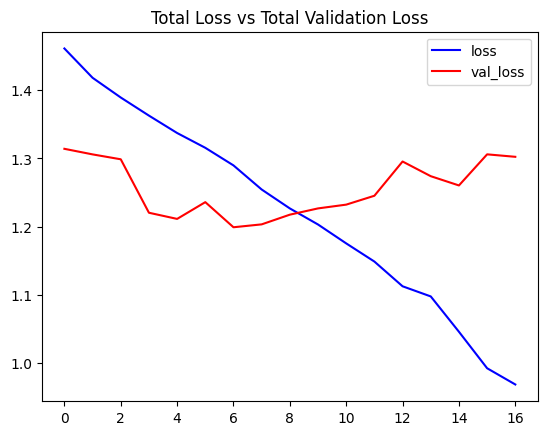

In [24]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss',
            'val_loss', 'Total Loss vs Total Validation Loss')

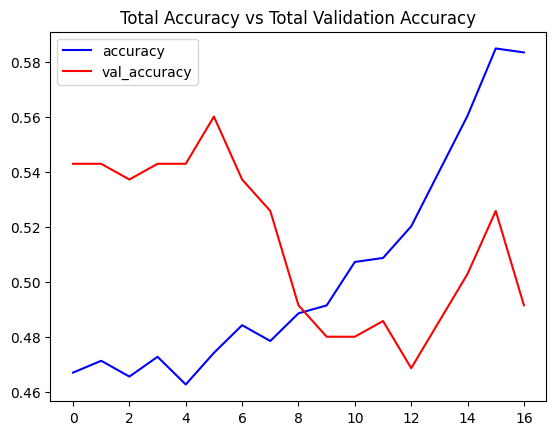

In [25]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy',
            'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [26]:
def create_LRCN_model():
    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(
        Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(
        Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(
        Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    # Display the model summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [27]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

d:\CV ASSIGNMENT\myenv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 10, 32, 32, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 8, 8, 32)   │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 2, 2, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 2, 2, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 2, 2, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 10, 1, 1, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 10, 0, 0, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 10, 0)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,901 (253.52 KB)

 Trainable params: 64,901 (253.52 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [35]:
# Print the shape of your input data
print("Input shape:", features_train.shape)

# Print the model summary to understand the output shapes of each layer
LRCN_model.summary()

# Ensure that the shapes match your expectations throughout the model architecture.

Input shape: (871, 10, 32, 32, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 10, 32, 32, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 8, 8, 32)   │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 2, 2, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 2, 2, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 2, 2, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 10, 1, 1, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 10, 0, 0, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 10, 0)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,901 (253.52 KB)

 Trainable params: 64,901 (253.52 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, LSTM, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Define your model
LRCN_model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3), activation='relu',
                    padding='same'), input_shape=(10, 32, 32, 3)),
    TimeDistributed(MaxPooling2D((2, 2), padding='same')),
    TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2, 2), padding='same')),
    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2, 2), padding='same')),
    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2, 2), padding='same')),
    TimeDistributed(Flatten()),
    LSTM(32),
    Dense(5, activation='softmax')
])

# Create an instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model with the specified loss function, optimizer, and metrics.
LRCN_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', metrics=['accuracy'])

# Print model summary for verification
LRCN_model.summary()

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(
    x=features_train,
    y=labels_train,
    epochs=70,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_15             │ (None, 10, 32, 32, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 10, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 10, 16, 16, 16) │         2,320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 10, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 10, 8, 8, 32)   │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 10, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 10, 4, 4, 32)   │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 10, 2, 2, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 10, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,429 (146.21 KB)

 Trainable params: 37,429 (146.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.4889 - loss: 1.4411 - val_accuracy: 0.5429 - val_loss: 1.2953
Epoch 2/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4914 - loss: 1.3287 - val_accuracy: 0.5829 - val_loss: 1.2330
Epoch 3/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5024 - loss: 1.2731 - val_accuracy: 0.5829 - val_loss: 1.2064
Epoch 4/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5046 - loss: 1.2338 - val_accuracy: 0.5714 - val_loss: 1.1907
Epoch 5/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5241 - loss: 1.1958 - val_accuracy: 0.5714 - val_loss: 1.1989
Epoch 6/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5356 - loss: 1.1539 - val_accuracy: 0.5657 - val_loss: 1.1906
Epoch 7/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5422 - loss: 1.1072 - val_accuracy: 0.5486 - val_loss: 1.2281
Epoch 8/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5900 - loss: 1.0646 - val_acc

In [23]:
# Evaluate the model on the test data
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the format for date and time in the file name
date_time_format = '%Y_%m_%d__%H_%M_%S'

# Get the current date and time
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(
    current_date_time_dt, date_time_format)

# Construct the model file name including evaluation metrics
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{
    model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the model
LRCN_model.save(model_file_name)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6416 - loss: 0.8263


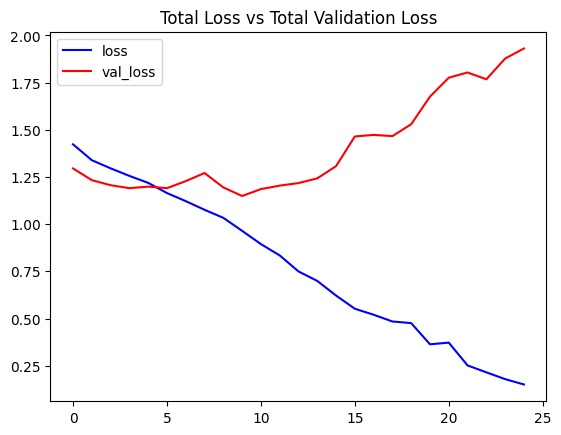

In [40]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss',
            'Total Loss vs Total Validation Loss')

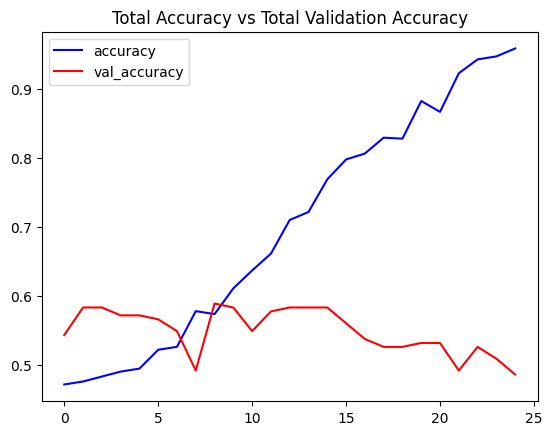

In [39]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy',
            'Total Accuracy vs Total Validation Accuracy')

In [38]:
# Make the Output directory if it does not exist
test_videos_directory = 'C:\\Users\\anukr\\Downloads\\test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Specify the video title (assuming it's already downloaded and named 'testing_01.mp4')
video_title = 'testing_01'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Define the required parameters
SEQUENCE_LENGTH = 16  # or the sequence length you used in training
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224  # or the image size you used in training
CLASSES_LIST = ['run', 'stand', 'talk', 'climb', 'walk']
LRCN_model = video_title  # the best performing model (replace with your actual model variable)

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, LRCN_model, CLASSES_LIST, IMAGE_HEIGHT, IMAGE_WIDTH):
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
    
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'XVID'), video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
    
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        # Read the frame.
        ok, frame = video_reader.read()
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
        
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255.0
        
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
        
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
            
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
            
            # Write predicted class name on top of the frame.
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
    
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.avi'
print(input_video_file_path, output_video_file_path)

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH, LRCN_model, CLASSES_LIST, IMAGE_HEIGHT, IMAGE_WIDTH)

C:\Users\anukr\Downloads\test_videos/testing_01.mp4 C:\Users\anukr\Downloads\test_videos/testing_01-Output-SeqLen16.avi
